# Exploring defining single value indices - SPI

This notebook contains several explorations and developments leading to the SPI framework.

# Setup

## Import Libraries


In [8]:
import soundscapy as sspy
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
import utils
import rpyskewnorm as snpy
import numpy as np
from MultiSkewNorm import MultiSkewNorm

import warnings

warnings.filterwarnings("ignore")

## Load Data

In addition to loading the latest version of the ISD, we also exclude a few samples that were identified as survey outliers. Most notably, this includes the samples at RegentsParkFields which were impacted by helicopter flyovers.

In [9]:
# Load latest ISD dataset

data = sspy.isd.load()
data, excl_data = sspy.isd.validate(data)
data = data.query("Language != 'cmn'")

# Exclude RegentsParkJapan outliers
# excl_id = list(data.query("LocationID == 'RegentsParkJapan'").query("ISOEventful > 0.72 | ISOEventful < -0.5").index)
# Excluded RegentsParkFields outliers
# excl_id = excl_id + list(data.query("LocationID == 'RegentsParkFields' and ISOPleasant < 0").index) # Helicopters
excl_id = [652, 706, 548, 550, 551, 553, 569, 580, 609, 618, 623, 636, 643]
data.drop(excl_id, inplace=True)
data

Renaming PAQ columns.
Checking PAQ data quality.
Identified 109 samples to remove.
[6, 9, 13, 30, 32, 46, 190, 213, 229, 244, 296, 412, 413, 428, 464, 485, 655, 734, 739, 762, 766, 780, 1067, 1274, 1290, 1316, 1320, 1338, 1346, 1347, 1397, 1425, 1431, 1446, 1447, 1470, 1485, 1491, 1504, 1505, 1510, 1512, 1517, 1522, 1523, 1527, 1599, 1698, 1734, 1817, 1911, 1948, 2069, 2107, 2109, 2111, 2150, 2199, 2277, 2293, 2384, 2386, 2490, 2523, 2584, 2592, 2695, 2762, 2767, 2783, 2789, 2825, 2826, 2832, 2840, 2856, 2859, 2879, 2883, 2889, 2910, 2932, 2956, 2969, 3031, 3058, 3077, 3124, 3149, 3163, 3185, 3202, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3272, 3302, 3365, 3414, 3491, 3502, 3510, 3517, 3533, 3583]


,LocationID,SessionID,GroupID,RecordID,start_time,end_time,latitude,longitude,Language,Survey_Version,...,RA_cp90_Max,RA_cp95_Max,THD_THD_Max,THD_Min_Max,THD_Max_Max,THD_L5_Max,THD_L10_Max,THD_L50_Max,THD_L90_Max,THD_L95_Max
0,CarloV,CarloV2,2CV12,1434,2019-05-16 18:46:00,2019-05-16 18:56:00,37.17685,-3.590392,eng,engISO2018,...,8.15,6.72,-0.09,-11.76,54.18,34.82,26.53,5.57,-9.00,-10.29
1,CarloV,CarloV2,2CV12,1435,2019-05-16 18:46:00,2019-05-16 18:56:00,37.17685,-3.590392,eng,engISO2018,...,8.15,6.72,-0.09,-11.76,54.18,34.82,26.53,5.57,-9.00,-10.29
2,CarloV,CarloV2,2CV13,1430,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,5.00,3.91,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.30,-17.33
3,CarloV,CarloV2,2CV13,1431,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,5.00,3.91,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.30,-17.33
4,CarloV,CarloV2,2CV13,1432,2019-05-16 19:02:00,2019-05-16 19:12:00,37.17685,-3.590392,eng,engISO2018,...,5.00,3.91,-2.10,-19.32,72.52,32.33,24.52,0.25,-16.30,-17.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,Noorderplantsoen,Noorderplantsoen1,NP161,61,2020-03-11 12:42:00,2020-03-11 12:55:00,NaN,NaN,nld,nldSSIDv1,...,2.54,2.00,-3.17,-11.97,59.64,37.87,26.54,6.33,-9.79,-10.34
1694,Noorderplantsoen,Noorderplantsoen1,NP162,63,2020-03-11 12:39:00,2020-03-11 13:00:00,NaN,NaN,nld,nldSSIDv1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1695,Noorderplantsoen,Noorderplantsoen1,NP162,62,2020-03-11 12:54:00,2020-03-11 12:58:00,NaN,NaN,nld,nldSSIDv1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1696,Noorderplantsoen,Noorderplantsoen1,NP162,64,2020-03-11 12:56:00,2020-03-11 12:59:00,NaN,NaN,nld,nldSSIDv1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### ISOCoordinate calculation according to Aletta et. al. (2024)



To move the 8-item PAQ responses into the 2-dimensional circumplex space, we use the projection method first presented in ISO 12913-3:2018. This projection method and its associated formulae were recently updated further in @Aletta2024 to include a correction for the language in which the survey was conducted. The formulae are as follows:

$$
% \begin{align*}
P_{ISO} = \frac{1}{\lambda_{pl}} \sum_{i=1}^{8} \cos \theta_i \cdot \sigma_i \\
E_{ISO} = \frac{1}{\lambda_{pl}} \sum_{i=1}^{8} \sin \theta_i \cdot \sigma_i 
% \end{align*}
$$

where $\text{PAQ}_i\$ is the response to the \(i\)th item of the PAQ. The resulting \(x\) and \(y\) values are then used to calculate the polar angle \(\theta\) and the radial distance \(r\) as follows:

In [10]:
from soundscapy.utils.parameters import LANGUAGE_ANGLES, PAQ_IDS

LANGUAGE_ANGLES

{'eng': (0, 46, 94, 138, 177, 241, 275, 340),
 'arb': (0, 36, 45, 135, 167, 201, 242, 308),
 'cmn': (0, 18, 38, 154, 171, 196, 217, 318),
 'hrv': (0, 84, 93, 160, 173, 243, 273, 354),
 'nld': (0, 43, 111, 125, 174, 257, 307, 341),
 'deu': (0, 64, 97, 132, 182, 254, 282, 336),
 'ell': (0, 72, 86, 133, 161, 233, 267, 328),
 'ind': (0, 53, 104, 123, 139, 202, 284, 308),
 'ita': (0, 57, 104, 143, 170, 274, 285, 336),
 'spa': (0, 41, 103, 147, 174, 238, 279, 332),
 'swe': (0, 66, 87, 146, 175, 249, 275, 335),
 'tur': (0, 55, 97, 106, 157, 254, 289, 313)}

In [11]:
#| label: tbl-lang-angles
#| tbl-cap: Language-specific angles for projection into the ISO 12913-3:2018 circumplex space.
tab = pd.DataFrame.from_dict(LANGUAGE_ANGLES, orient='index', columns=PAQ_IDS)
tab

,PAQ1,PAQ2,PAQ3,PAQ4,PAQ5,PAQ6,PAQ7,PAQ8
eng,0,46,94,138,177,241,275,340
arb,0,36,45,135,167,201,242,308
cmn,0,18,38,154,171,196,217,318
hrv,0,84,93,160,173,243,273,354
nld,0,43,111,125,174,257,307,341
deu,0,64,97,132,182,254,282,336
ell,0,72,86,133,161,233,267,328
ind,0,53,104,123,139,202,284,308
ita,0,57,104,143,170,274,285,336
spa,0,41,103,147,174,238,279,332


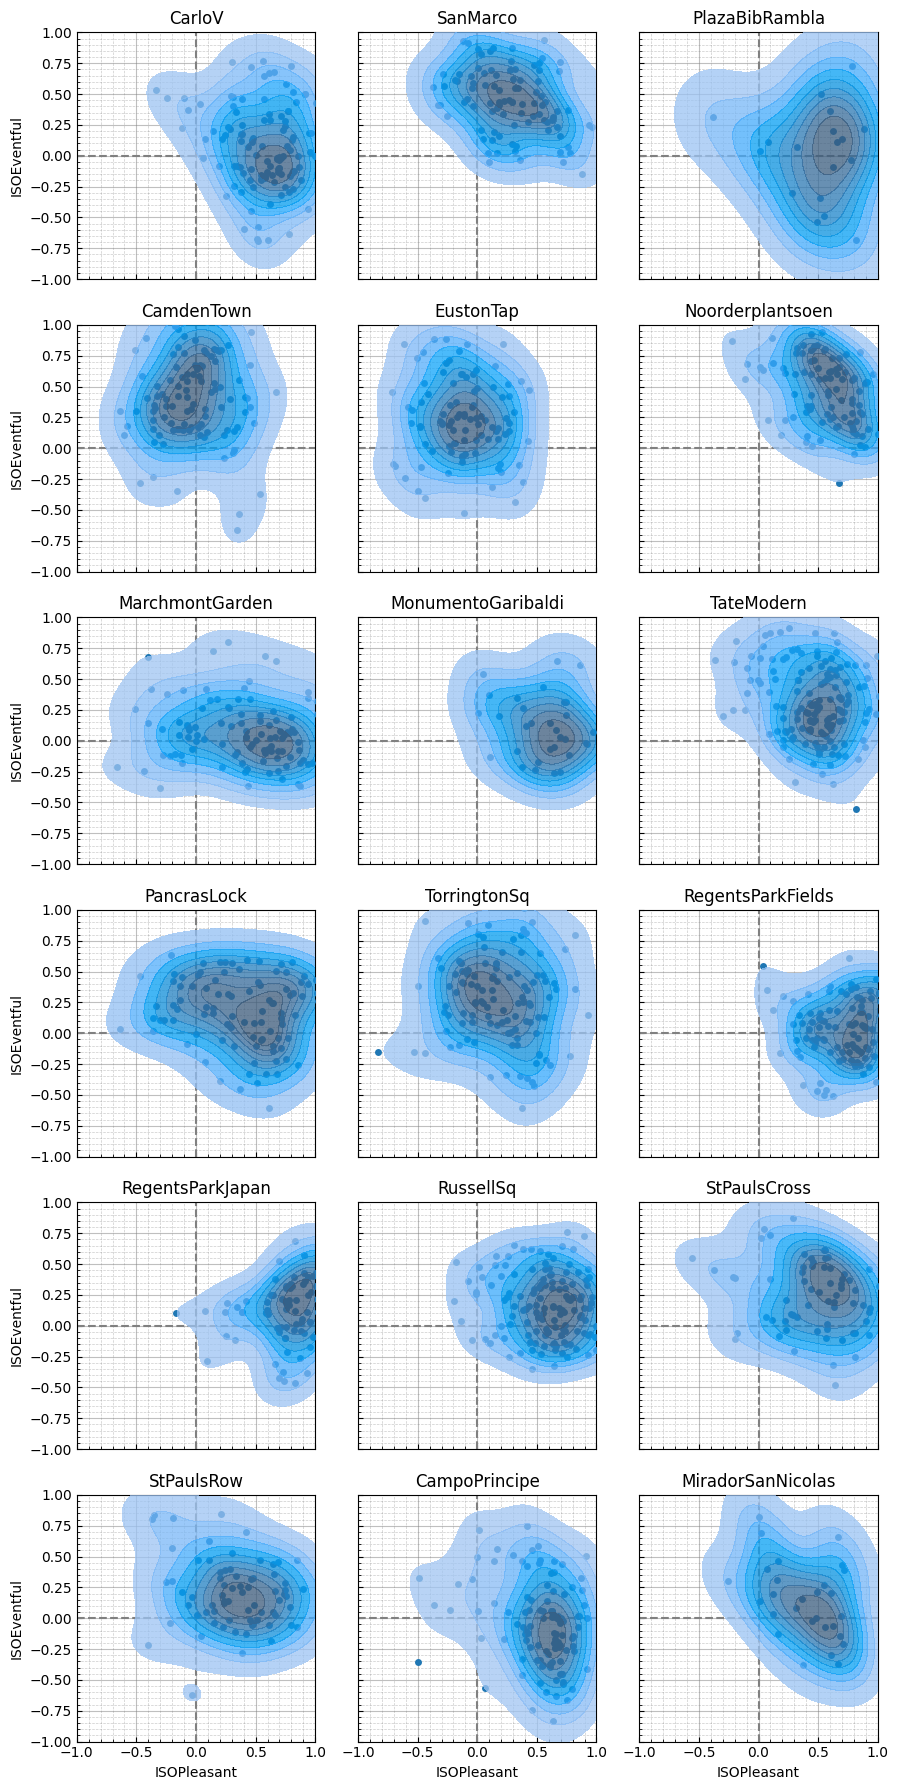

In [12]:
from soundscapy.utils.parameters import PAQ_IDS

for i, row in data.iterrows():
    lang = row["Language"]
    angles = LANGUAGE_ANGLES[lang]
    iso_pl, iso_ev = (
        sspy.surveys.adj_iso_pl(row[PAQ_IDS], angles, scale=4),
        sspy.surveys.adj_iso_ev(row[PAQ_IDS], angles, scale=4),
    )
    data.loc[i, "ISOPleasant"] = iso_pl
    data.loc[i, "ISOEventful"] = iso_ev

fig, axes = plt.subplots(6, 3, figsize=(9, 18), sharex=True, sharey=True)
for i, (loc, ax) in enumerate(zip(data.LocationID.unique(), axes.flatten())):
    sspy.plotting.density(
        data.query(f"LocationID == '{loc}'"),
        ax=ax,
        title=loc,
        # hue='Language',
    )

fig.tight_layout()

R[write to console]: Error in chol.default(lot$aux$Psi) : 
  the leading minor of order 2 is not positive



RRuntimeError: Error in chol.default(lot$aux$Psi) : 
  the leading minor of order 2 is not positive


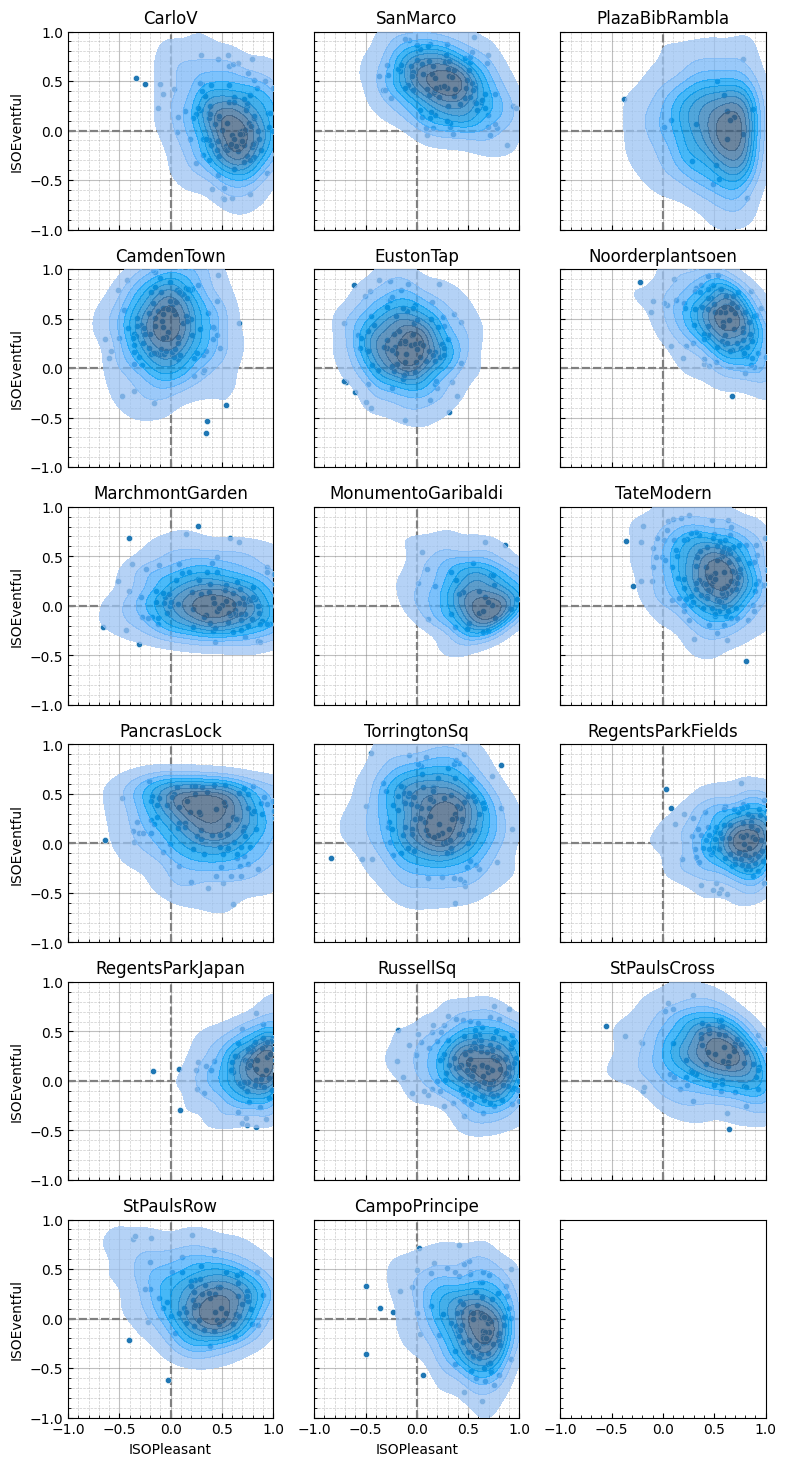

In [13]:
# Plotting distribution density with empirical scatter

fig, axes = plt.subplots(6, 3, figsize=(9, 18), sharex=True, sharey=True)
for i, (loc, ax) in enumerate(zip(data.LocationID.unique(), axes.flatten())):
    loc_msn = MultiSkewNorm()
    loc_msn.fit(
        data=data.query(f"LocationID == '{loc}'")[["ISOPleasant", "ISOEventful"]]
    )
    loc_msn.sample(1000)
    loc_Y = pd.DataFrame(loc_msn.sample_data, columns=["ISOPleasant", "ISOEventful"])

    sspy.plotting.scatter(
        data.query(f"LocationID == '{loc}'"),
        ax=ax,
        title=loc,
    )
    sspy.plotting.density(
        loc_Y,
        ax=ax,
        title=loc,
        incl_scatter=False,
        # hue='Language',
    )

fig.tight_layout()

## The Soundscape Perception Index (SPI)

The SPI works by assessing the assessed (or calculated) distribution of soundscape responses against a target distribution. This target distribution represents the goal for the soundscape design. Since we consider a location's soundscape perception to be the collective perception of its users, it is crucial that the target includes both the central tendency and the distribution. 

### Note: Distributions in the circumplex

We should begin by discussing how soundscape circumplex distributions are defined. The circumplex is defined by two axes: $P_{ISO}$ and $E_{ISO}$ which are limited to the range $[-1,1]$. Typically the distribution of collective perception of a soundscape is also not symmetrical, therefore making it a skewed distribution. A soundscape distribution is thus a two-dimensional truncated skew-normal distribution.

The skew-normal distribution is defined by three parameters: location, scale and shape. The location parameter defines the centre of the distribution, the scale parameter defines the spread of the distribution, and the shape parameter defines the skew of the distribution. The skew-normal distribution is defined as:

$$
f(x; a, \omega, \alpha) = \frac{2}{\omega} \phi \left( \frac{x-a}{\omega} \right) \Phi \left( \alpha \frac{x-a}{\omega} \right)
$$

where $\phi$ and $\Phi$ are the standard normal probability density function and cumulative distribution function respectively. The skew-normal distribution is thus a generalisation of the normal distribution, with the shape parameter $\alpha$ defining the skew. A positive shape parameter results in a right-skewed distribution, and a negative shape parameter results in a left-skewed distribution.

Truncated skew-normal distribution: https://www-tandfonline-com.libproxy.ucl.ac.uk/doi/epdf/10.1080/03610910902936109?needAccess=true

To generate the truncated skew-normal distribution, we use rejection sampling. This is a method of generating a distribution by sampling from a simpler distribution and rejecting samples that do not fit the target distribution. In this case, we sample from a skew-normal distribution (`scipy.stats.skewnorm`) and reject samples that are outside of the range $[-1,1]$.

#### Example - Calculating the moments of location's distribution and generating the equivalent distribution using rejection sampling



In [14]:
test_loc = "SanMarco"
test_data = sspy.isd.select_location_ids(data, test_loc)

msn = MultiSkewNorm()
msn.fit(data=test_data[["ISOPleasant", "ISOEventful"]])

msn.summary()

Fitted from data. n = 95
Direct Parameters:
xi:    [[0.065 0.629]]
omega: [[ 0.149 -0.064]
 [-0.064  0.101]]
alpha: [ 0.791 -0.767]


Centred Parameters:
mean:  [[0.283 0.451]]
sigma: [[ 0.102 -0.026]
 [-0.026  0.07 ]]
skew:  [ 0.136 -0.131]


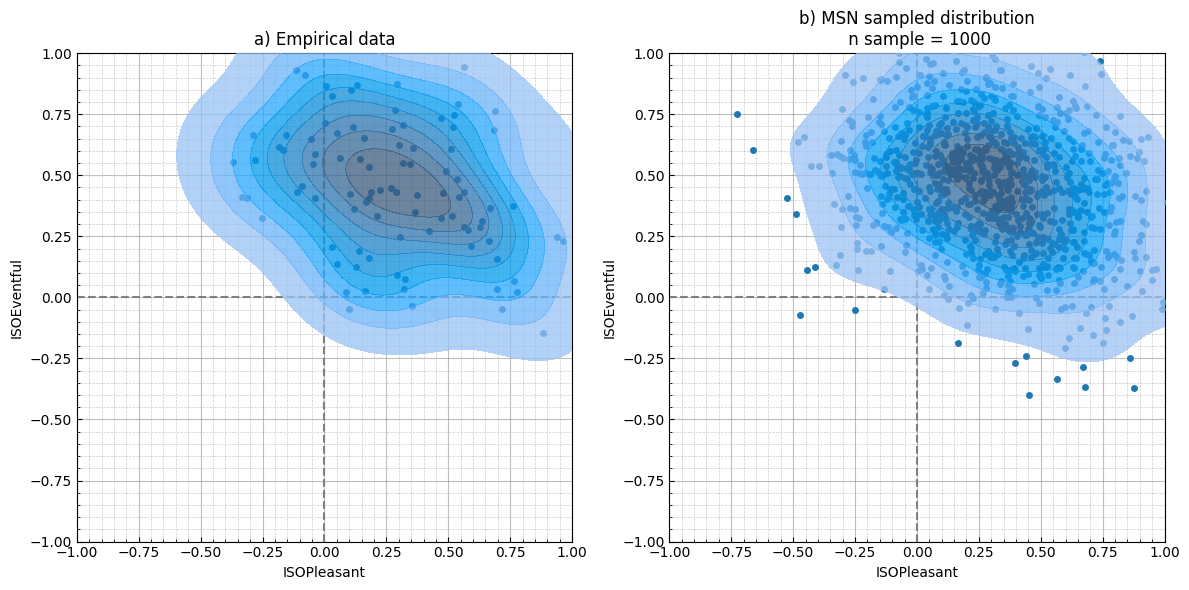

In [15]:
#| label: fig-dist-example
#| fig-cap: Example of fitting and sampling from a multivariate skew-normal distribution for data from the Piazza San Marco location.

Y = msn.sample(1000, return_sample=True)
Y = pd.DataFrame(Y, columns=["ISOPleasant", "ISOEventful"])
D, p = msn.ks2ds(test_data[["ISOPleasant", "ISOEventful"]])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sspy.plotting.density(
    test_data,
    ax=axes[0],
    density_type="full",
    title=f"a) Empirical data",
)
sspy.plotting.density(
    Y, ax=axes[1], density_type="full", title="b) MSN sampled distribution\n n sample = 1000"
)
plt.tight_layout()

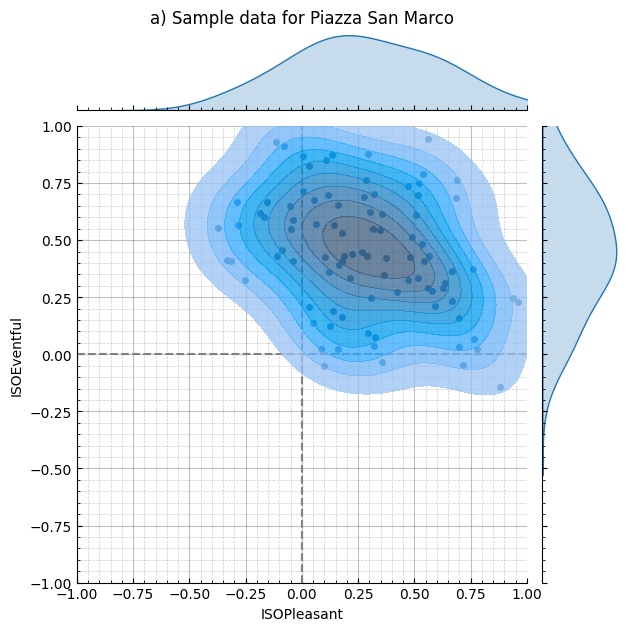

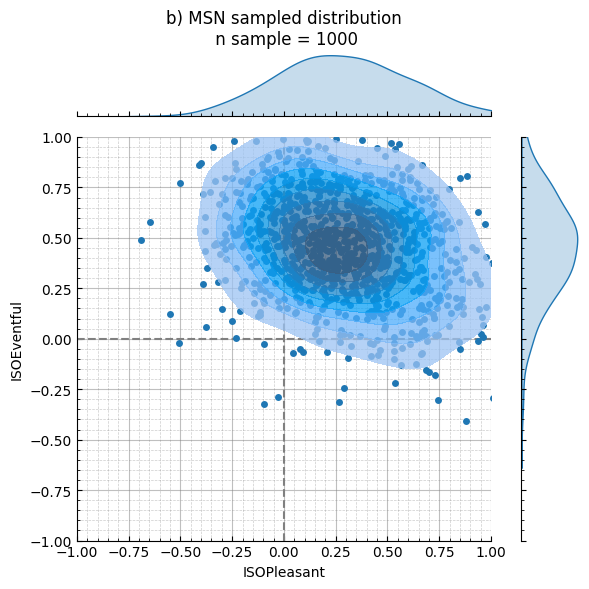

In [16]:
Y = msn.sample(1000, return_sample=True)
Y = pd.DataFrame(Y, columns=["ISOPleasant", "ISOEventful"])
D, p = msn.ks2ds(test_data[["ISOPleasant", "ISOEventful"]])

sspy.plotting.jointplot(
    test_data,
    density_type="full",
    title=f"a) Sample data for Piazza San Marco",
)
sspy.plotting.jointplot(
    Y, density_type="full", title="b) MSN sampled distribution\n n sample = 1000"
)
plt.tight_layout()

In [17]:
# Universal pleasant target
target_1 = MultiSkewNorm()
target_1.define_dp(
    xi = np.array([0.5, 0.0]),
    omega = np.array(
        [[0.2, 0],
         [0, 0.2]]),
    alpha = np.array([1, 0])
)
target_2 = MultiSkewNorm()
target_2.define_dp(
    xi = np.array([[1.0, -0.4]]),
    omega = np.array([[ 0.17, -0.04],
              [-0.04,  0.09]]),
    alpha = np.array([-8,  1])
    )

target_3 = MultiSkewNorm()
target_3.define_dp(
    xi=np.array([0.5, 0.7]),
    omega=np.array([[0.1, 0.05], [0.05, 0.1]]),
    alpha=np.array([0, -5]),
)

Y_1 = target_1.sample(1000, return_sample=True)
Y_1 = pd.DataFrame(Y_1, columns=["ISOPleasant", "ISOEventful"])
Y_2 = target_2.sample(1000, return_sample=True)
Y_2 = pd.DataFrame(Y_2, columns=["ISOPleasant", "ISOEventful"])
Y_3 = target_3.sample(1000, return_sample=True)
Y_3 = pd.DataFrame(Y_3, columns=["ISOPleasant", "ISOEventful"])


<Axes: title={'center': 'c) Target 3'}, xlabel='ISOPleasant', ylabel='ISOEventful'>

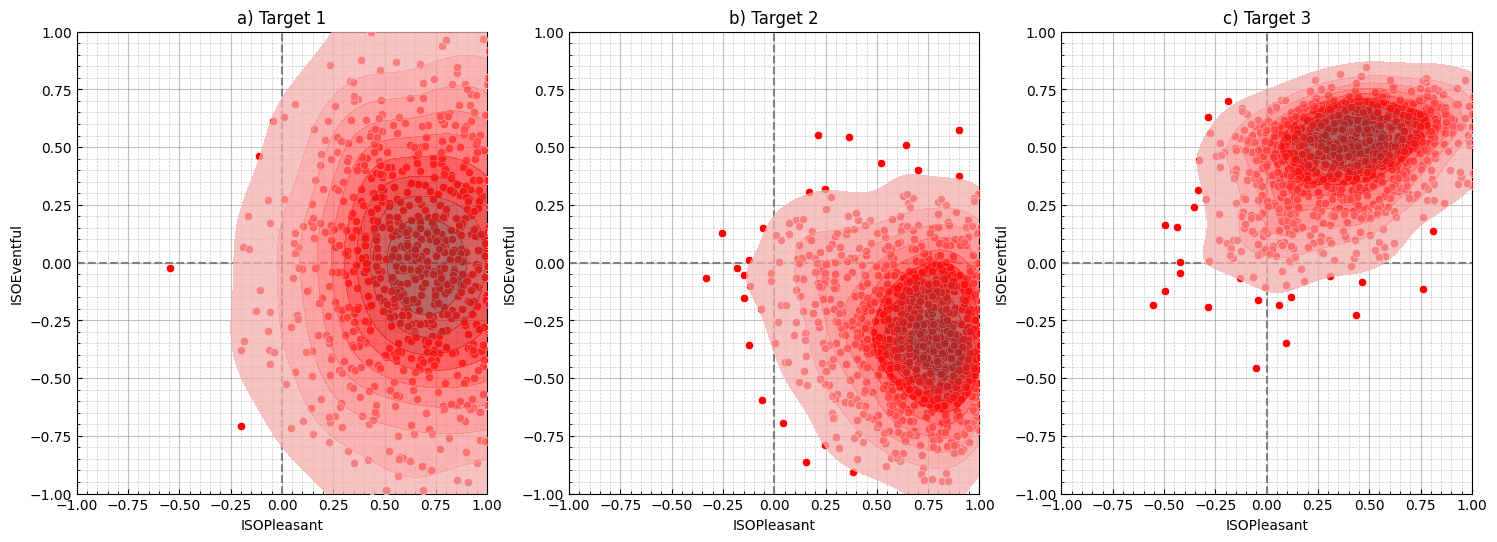

In [18]:
#| label: fig-targets
#| fig-cap: Example of defining and sampling from three arbitrary bespoke targets.

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sspy.plotting.density(
    Y_1,
    ax=axes[0],
    density_type="full",
    title="a) Target 1",
    color='red',
    scatter_kws={'color': 'red'}
)
sspy.plotting.density(
    Y_2, ax=axes[1], density_type="full", title="b) Target 2", color='red', scatter_kws={'color': 'red'}
)
sspy.plotting.density(
    Y_3, ax=axes[2], density_type="full", title="c) Target 3", color='red', scatter_kws={'color': 'red'}
)

In [19]:
D_1 = utils.ks2d2s(
    test_data = test_data[['ISOPleasant', 'ISOEventful']],
    target_data = Y_1,
    extra=True
)
D_2 = utils.ks2d2s(
    test_data = test_data[['ISOPleasant', 'ISOEventful']],
    target_data = Y_2,
    extra=True
)
D_3 = utils.ks2d2s(
    test_data = test_data[['ISOPleasant', 'ISOEventful']],
    target_data = Y_3,
    extra=True
)

In [20]:
#| label: tbl-ks-test
#| tbl-cap: Kolmogorov-Smirnov test comparing the empirical test distribution (Piazza San Marco) against three soundscape target distributions.
from IPython.display import Markdown
from tabulate import tabulate

D_tbl = [['tgt_1', D_1[1].round(2), D_1[0]],
         ['tgt_2', D_2[1].round(2), D_2[0]],
         ['tgt_3', D_3[1].round(2), D_2[0]]]
Markdown(tabulate(
    D_tbl,
    headers = ["Target", "D", "p"],
    tablefmt='grid'
))

+----------+------+-------------+
| Target   |    D |           p |
+==========+======+=============+
| tgt_1    | 0.67 | 4.01698e-25 |
+----------+------+-------------+
| tgt_2    | 0.84 | 6.90707e-40 |
+----------+------+-------------+
| tgt_3    | 0.28 | 6.90707e-40 |
+----------+------+-------------+

<Axes: title={'center': 'San Marco compared against target\nD=0.28, p=0.0001'}, xlabel='ISOPleasant', ylabel='ISOEventful'>

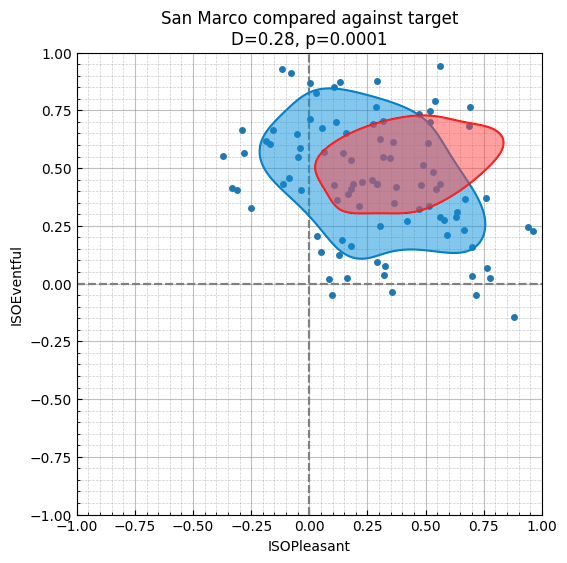

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))

sspy.plotting.density(
    sspy.isd.select_location_ids(data, "SanMarco"),
    ax=ax,
    density_type="simple",
    label='test',
)
sspy.plotting.density(
    x=target_3.sample_data[:, 0],
    y=target_3.sample_data[:, 1],
    ax=ax,
    incl_scatter=False,
    density_type="simple",
    label='target',
    title=f"San Marco compared against target\nD={D_3[1].round(2)}, p={D_3[0].round(4)}",
    color='red'
)

In [22]:
spis = {}
for location in data.LocationID.unique():
    loc_data = sspy.isd.select_location_ids(data, location)[['ISOPleasant', 'ISOEventful']]
    spi_res = [utils.spi(loc_data, target_data) for target_data in [Y_1, Y_2, Y_3]]
    spis[location] = spi_res
spis_df = pd.DataFrame(spis).T
spis_df.columns = ['tgt_1', 'tgt_2', 'tgt_3']
# spis_df

In [23]:
def table_fill(spis_df, idx):
    tgt_1_order = spis_df['tgt_1'].sort_values(ascending=False)
    tgt_2_order = spis_df['tgt_2'].sort_values(ascending=False)
    tgt_3_order = spis_df['tgt_3'].sort_values(ascending=False)

    def tgt_str(tgt_order, idx):
        return f"{tgt_order.values[idx]}   {tgt_order.index[idx]}"

    return [f"{idx+1}", tgt_str(tgt_1_order, idx), tgt_str(tgt_2_order, idx), tgt_str(tgt_3_order, idx)]


In [24]:
#| label: tbl-ex-spis
#| tbl-cap: SPI scores and rankings for the soundscapes of locations included in the International Soundscape Database (ISD).
spis_tbl = [table_fill(spis_df, idx) for idx in range(len(spis_df))]
tabulate.PRESERVE_WHITESPACE = True
Markdown(tabulate(
    spis_tbl,
    headers = ["Ranking", "$SPI_1$ (pleasant)", "$SPI_2$ (calm)", "$SPI_3$ (vibrant)"],
    tablefmt='pipe',
))

|   Ranking | $SPI_1$ (pleasant)      | $SPI_2$ (calm)          | $SPI_3$ (vibrant)       |
|----------:|:------------------------|:------------------------|:------------------------|
|         1 | 69   CarloV             | 61   CampoPrincipe      | 71   SanMarco           |
|         2 | 69   RegentsParkFields  | 55   CarloV             | 60   TateModern         |
|         3 | 64   RegentsParkJapan   | 50   RegentsParkFields  | 58   StPaulsCross       |
|         4 | 62   CampoPrincipe      | 48   PlazaBibRambla     | 58   Noorderplantsoen   |
|         5 | 60   RussellSq          | 44   MarchmontGarden    | 55   TorringtonSq       |
|         6 | 60   MarchmontGarden    | 44   MonumentoGaribaldi | 54   PancrasLock        |
|         7 | 60   MonumentoGaribaldi | 40   RussellSq          | 47   StPaulsRow         |
|         8 | 59   PlazaBibRambla     | 38   RegentsParkJapan   | 46   MiradorSanNicolas  |
|         9 | 58   PancrasLock        | 38   PancrasLock        | 45   RussellSq          |
|        10 | 51   StPaulsCross       | 32   StPaulsCross       | 43   CamdenTown         |
|        11 | 47   TateModern         | 32   MiradorSanNicolas  | 39   CarloV             |
|        12 | 47   StPaulsRow         | 29   TateModern         | 35   MonumentoGaribaldi |
|        13 | 42   MiradorSanNicolas  | 29   StPaulsRow         | 35   MarchmontGarden    |
|        14 | 38   Noorderplantsoen   | 28   TorringtonSq       | 33   PlazaBibRambla     |
|        15 | 37   TorringtonSq       | 15   SanMarco           | 33   CampoPrincipe      |
|        16 | 33   SanMarco           | 15   Noorderplantsoen   | 32   EustonTap          |
|        17 | 22   CamdenTown         | 14   EustonTap          | 27   RegentsParkJapan   |
|        18 | 15   EustonTap          | 14   CamdenTown         | 26   RegentsParkFields  |

In [25]:
spis_df['tgt_1'].sort_values(ascending=False)

CarloV                69
RegentsParkFields     69
RegentsParkJapan      64
CampoPrincipe         62
RussellSq             60
MarchmontGarden       60
MonumentoGaribaldi    60
PlazaBibRambla        59
PancrasLock           58
StPaulsCross          51
TateModern            47
StPaulsRow            47
MiradorSanNicolas     42
Noorderplantsoen      38
TorringtonSq          37
SanMarco              33
CamdenTown            22
EustonTap             15
Name: tgt_1, dtype: int64

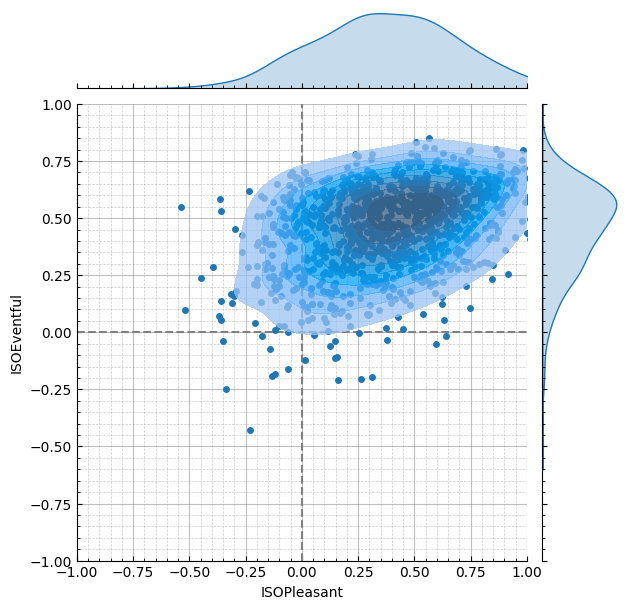

In [26]:
target = MultiSkewNorm()
target.define_dp(
    xi=np.array([0.5, 0.7]),
    omega=np.array([[0.1, 0.05], [0.05, 0.1]]),
    alpha=np.array([0, -5]),
)
target.sample(1000)
target.sspy_plot()

<Axes: title={'center': 'Target Density'}, xlabel='ISOPleasant', ylabel='ISOEventful'>

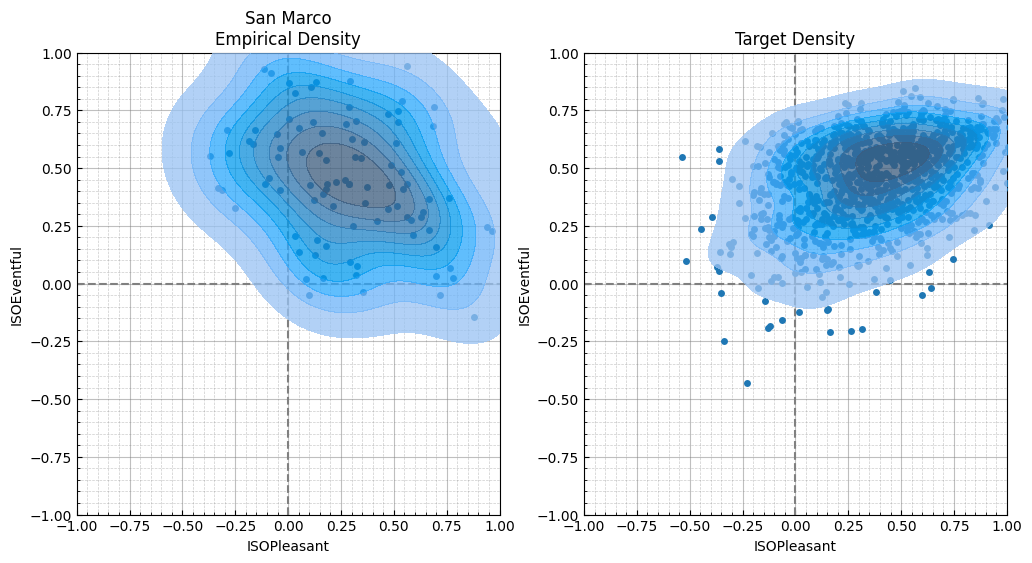

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sspy.plotting.density(
    test_data, incl_scatter=True, title="San Marco\nEmpirical Density", ax=axes[0]
)
sspy.plotting.density(
    pd.DataFrame(target.sample_data, columns=["ISOPleasant", "ISOEventful"]),
    incl_scatter=True,
    title="Target Density",
    ax=axes[1],
)

Once the target is defined, we will generate a set of points that represent the target distribution. 

Now that our target has been defined, we can calculate the SPI for a given set of responses. We will use the responses from Piazza San Marco in Venice, Italy, as an example.

In [28]:
test_spi = target.spi(data.query("LocationID == 'SanMarco'")[["ISOPleasant", "ISOEventful"]])
print(f"San Marco SPI = {test_spi}")

San Marco SPI = 73


<Axes: title={'center': 'Piazza San Marco\nSPI = 73'}, xlabel='ISOPleasant', ylabel='ISOEventful'>

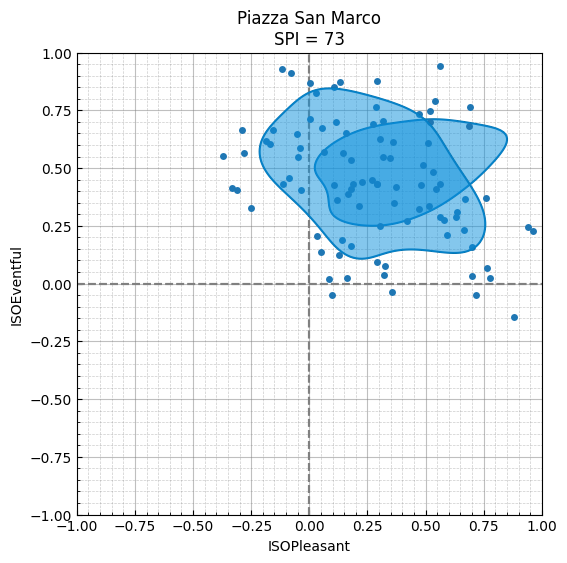

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))

sspy.plotting.density(
    x=target.sample_data[:, 0],
    y=target.sample_data[:, 1],
    ax=ax,
    incl_scatter=False,
    density_type="simple",
    title="",
)
sspy.plotting.density(
    sspy.isd.select_location_ids(data, "SanMarco"),
    ax=ax,
    density_type="simple",
    title=f"Piazza San Marco\nSPI = {test_spi}",
)

We can compare this against another location, such as St Pancras Lock.

<Axes: title={'center': 'Pancras Lock\nSPI = 56'}, xlabel='ISOPleasant', ylabel='ISOEventful'>

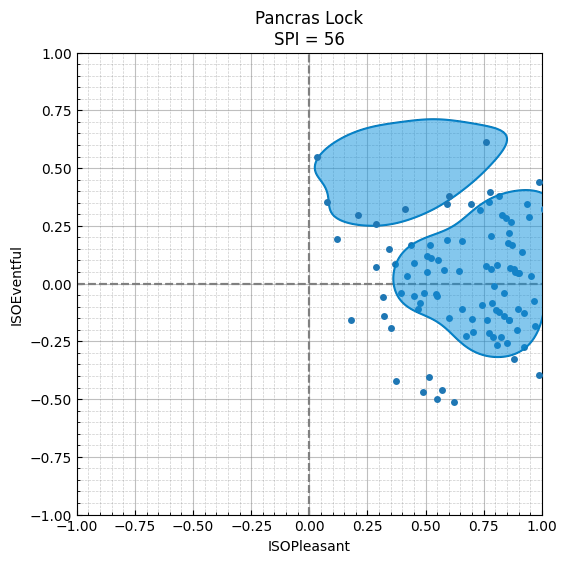

In [30]:
test_spi = target.spi(
    sspy.isd.select_location_ids(data, "PancrasLock")[["ISOPleasant", "ISOEventful"]]
)
fig, ax = plt.subplots(figsize=(6, 6))

sspy.plotting.density(
    x=target.sample_data[:, 0],
    y=target.sample_data[:, 1],
    ax=ax,
    incl_scatter=False,
    density_type="simple",
    title="",
)
sspy.plotting.density(
    sspy.isd.select_location_ids(data, "RegentsParkFields"),
    ax=ax,
    density_type="simple",
    title=f"Pancras Lock\nSPI = {test_spi}",
)

SPI scores assessed against a target should not inherently be considered a measure of the quality of the soundscape - instead it reflects the degree to which the soundscape matches the target. A high SPI score does not necessarily mean that the soundscape is of high quality, but rather that the soundscape is of high quality *according to the target*.

The $SPI_{bespoke}$ thus provides a method for scoring and ranking the success of a soundscape design against the designer's goals. Sticking with our defined target, we can assess all of the locations in the ISD and see which locations best match our target.

In [31]:
loc_bespoke = {}
for location in data.LocationID.unique():
    loc_bespoke[location] = target.spi(
        sspy.isd.select_location_ids(data, location)[["ISOPleasant", "ISOEventful"]]
    )

loc_bespoke = pd.DataFrame.from_dict(loc_bespoke, orient="index", columns=["SPI"])
loc_bespoke.sort_values(by="SPI", ascending=False, inplace=True)
loc_bespoke

,SPI
SanMarco,73
TateModern,61
StPaulsCross,60
Noorderplantsoen,60
PancrasLock,56
TorringtonSq,56
StPaulsRow,49
MiradorSanNicolas,47
RussellSq,46
CamdenTown,44


Assessed against a different target would result in a different ranking:

Fitted from direct parameters.
Direct Parameters:
xi:    [-0.5 -0.5]
omega: [[0.1 0. ]
 [0.  0.2]]
alpha: [-0.85  1.5 ]


None


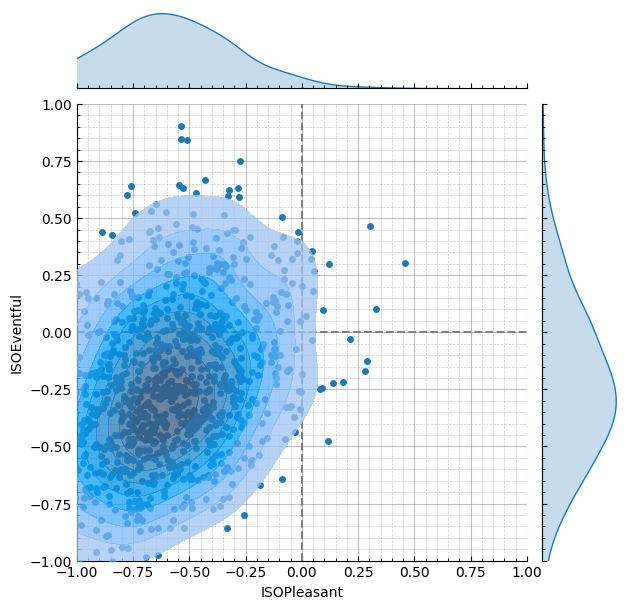

In [32]:
target = MultiSkewNorm()
target.define_dp(
    np.array([-0.5, -0.5]),
    np.array([[0.1, 0], [0, 0.2]]),
    np.array([-0.85, 1.5]),
)
target.summary()

target.sample(n=1000)
target.sspy_plot()

In [33]:
loc_bespoke_2 = {}
for location in data.LocationID.unique():
    loc_bespoke_2[location] = target.spi(
        sspy.isd.select_location_ids(data, location)[["ISOPleasant", "ISOEventful"]]
    )

loc_bespoke_2 = pd.DataFrame.from_dict(loc_bespoke_2, orient="index", columns=["SPI"])
loc_bespoke_2.sort_values(by="SPI", ascending=False, inplace=True)
loc_bespoke_2

,SPI
EustonTap,31
CamdenTown,22
MarchmontGarden,18
TorringtonSq,18
PancrasLock,17
PlazaBibRambla,16
StPaulsRow,14
CampoPrincipe,10
StPaulsCross,10
SanMarco,8


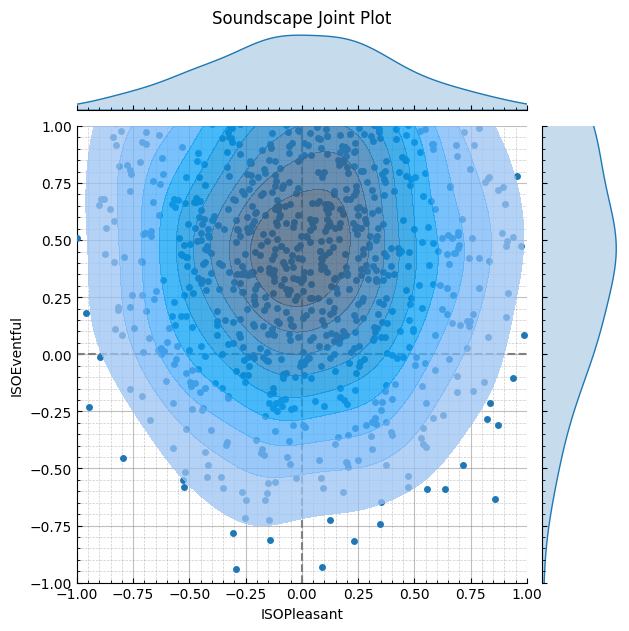

In [34]:
target1 = MultiSkewNorm()
target1.define_dp(
    np.array([-0.5, 0.5]), np.array([[0.1, 0], [0, 0.1]]), np.array([0, 0])
)
target1.sample()

target2 = MultiSkewNorm()
target2.define_dp(np.array([0.5, 0]), np.array([[0.1, 0], [0, 0.2]]), np.array([0, 0]))
target2.sample()

target_mix_y = target1.sample_data + target2.sample_data

target_mix_y = pd.DataFrame(target_mix_y, columns=["ISOPleasant", "ISOEventful"])

sspy.plotting.jointplot(target_mix_y)